# ESI Prediction Using Various Models
This notebook loads a dataset, processes the data, and applies K-Nearest Neighbors (KNN) and Support Vector Machine (SVM) classification.

# Import necessary libraries


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import mord
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
!pip install imbalanced-learn


# Load Data


In [5]:
print("Loading data...")
df = pd.read_csv("C:/Users/DELL/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Desktop/Machine Learning/FinalMlfast.csv", nrows=30000)

Loading data...


# 1. Data Overview:


In [7]:
# Checking basic information
print(df.info())

# Checking the first few rows
print(df.head())

# Checking for any summary statistics of numerical features
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 972 entries, dep_name to cc_wristpain
dtypes: float64(589), int64(368), object(15)
memory usage: 222.5+ MB
None
  dep_name  esi   age  gender           ethnicity  \
0        B  4.0  40.0    Male  Hispanic or Latino   
1        B  4.0  66.0    Male  Hispanic or Latino   
2        B  2.0  66.0    Male  Hispanic or Latino   
3        A  2.0  66.0    Male  Hispanic or Latino   
4        A  3.0  84.0  Female  Hispanic or Latino   

                                        race     lang     religion  \
0                         White or Caucasian  English          NaN   
1  Native Hawaiian or Other Pacific Islander  English  Pentecostal   
2  Native Hawaiian or Other Pacific Islander  English  Pentecostal   
3  Native Hawaiian or Other Pacific Islander  English  Pentecostal   
4                                      Other    Other  Pentecostal   

  maritalstatus  employstatus  ... cc_vaginaldischarge cc_vagin

 ### Display Top Correlations

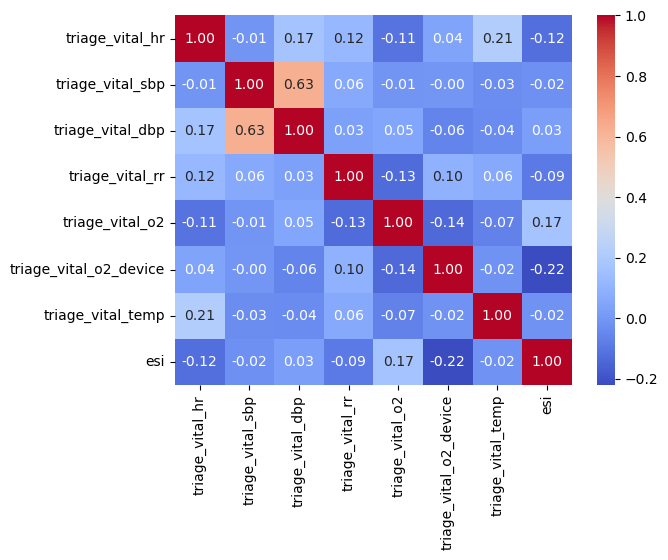

In [9]:
# Select only numeric columns, including the ones you are interested in
selected_columns = [col for col in df.columns if col.startswith('triage')] + ['esi']

# Filter out non-numeric columns from the selected columns
df_numeric = df[selected_columns].select_dtypes(include=[np.number])

# Calculate correlations
corr_matrix = df_numeric.corr()

# Plot heatmap for selected columns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()



### Handling Missing Values and Feature Selection

1. **Handle Missing Values**: 
   We begin by handling missing values in the target variable (`esi`) and the `age` feature. Any rows with missing values in these columns are removed.
   ```python

In [11]:
# Handle missing values in target variable and age
print("Handling missing values...")
df = df.dropna(subset=['esi', 'age'])
df = df[df["esi"] != 0]
df = df[df["age"] != 0]

Handling missing values...


In [12]:
# Ensure 'esi' is retained
selected_features = ['esi', 'age', 'gender', 'arrivalmode', 'previousdispo',
    'triage_vital_hr', 'triage_vital_rr', 'triage_vital_sbp', 
    'triage_vital_dbp', 'triage_vital_o2', 'triage_vital_temp']


In [13]:

# Add past medical history columns
if '2ndarymalig' in df.columns and 'whtblooddx' in df.columns:
    medical_history_cols = list(df.loc[:, '2ndarymalig':'whtblooddx'].columns)
    selected_features.extend(medical_history_cols)

In [14]:

# Add chief complaints columns
chief_complaint_cols = [col for col in df.columns if col.startswith('cc_')]
selected_features.extend(chief_complaint_cols)


In [15]:

# Filter selected features
selected_features = [f for f in selected_features if f in df.columns]
df = df[selected_features].copy()

In [16]:
# Assuming you have a DataFrame called df
duplicates = df[df.duplicated()]

print("Duplicate rows in the dataset:")
print(duplicates)

Duplicate rows in the dataset:
       esi   age  gender arrivalmode previousdispo  triage_vital_hr  \
73     5.0  32.0  Female         NaN     Discharge              NaN   
125    3.0  71.0  Female   ambulance         Admit              NaN   
885    2.0  84.0  Female   ambulance         Admit              NaN   
1217   2.0  63.0  Female   ambulance         Admit              NaN   
1247   3.0  85.0    Male   ambulance         Admit              NaN   
...    ...   ...     ...         ...           ...              ...   
29814  2.0  50.0  Female   ambulance     Discharge              NaN   
29815  2.0  50.0  Female   ambulance     Discharge              NaN   
29816  2.0  50.0  Female   ambulance     Discharge              NaN   
29819  2.0  50.0  Female   ambulance     Discharge              NaN   
29955  3.0  29.0  Female   ambulance     Discharge              NaN   

       triage_vital_rr  triage_vital_sbp  triage_vital_dbp  triage_vital_o2  \
73                 NaN               

In [17]:
df = df.drop_duplicates(keep='first')


### One-Hot Encoding Categorical Features

1. **Identify Categorical Columns**:
   We define the columns that we want to one-hot encode, which are `gender`, `arrivalmode`, and `previousdispo`. We then ensure that these columns exist in the dataframe.
  


# One-hot encode categorical features


In [20]:
print("One-hot encoding categorical features...")
categorical_cols = ['gender', 'arrivalmode', 'previousdispo']
categorical_cols = [col for col in categorical_cols if col in df.columns]

if categorical_cols:
    df[categorical_cols] = df[categorical_cols].fillna("Unknown")

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cats = encoder.fit_transform(df[categorical_cols])

    new_cols = [f"{col}_{category}" for col, categories in zip(categorical_cols, encoder.categories_) for category in categories]
    encoded_df = pd.DataFrame(encoded_cats, index=df.index, columns=new_cols)

    df = df.drop(columns=categorical_cols).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)

print("One-hot encoding complete!")

One-hot encoding categorical features...
One-hot encoding complete!


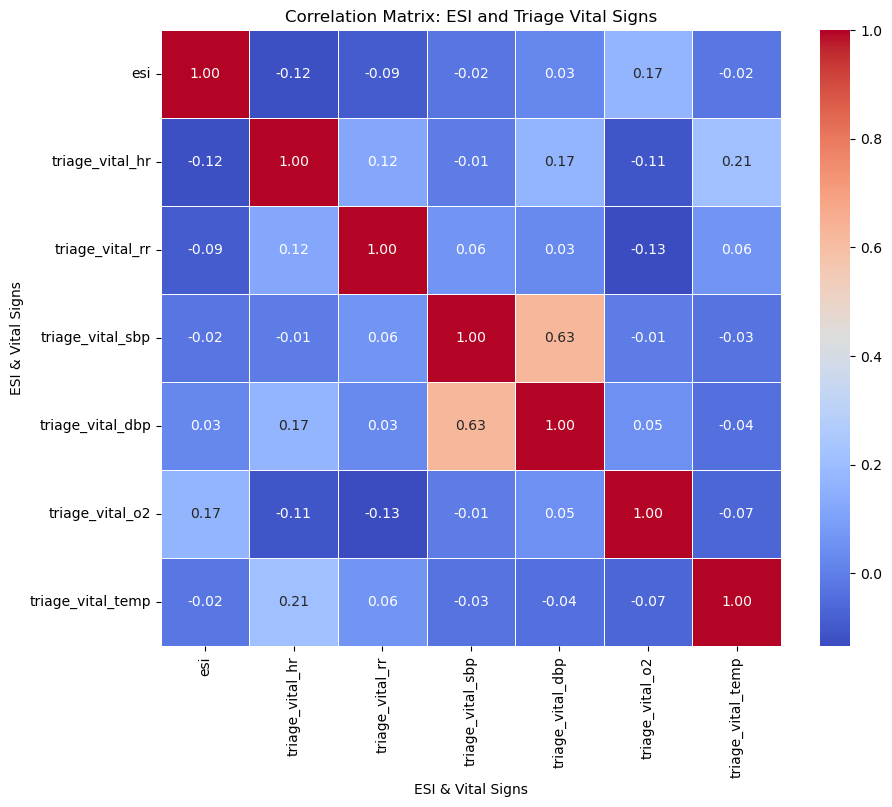

In [21]:
# Compute correlation matrix between ESI and Triage Vital Signs
vital_signs = ['esi', 'triage_vital_hr', 'triage_vital_rr', 'triage_vital_sbp', 
               'triage_vital_dbp', 'triage_vital_o2', 'triage_vital_temp']

correlation_matrix_vital = df[vital_signs].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_vital, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: ESI and Triage Vital Signs")
plt.xlabel("ESI & Vital Signs")
plt.ylabel("ESI & Vital Signs")
plt.show()


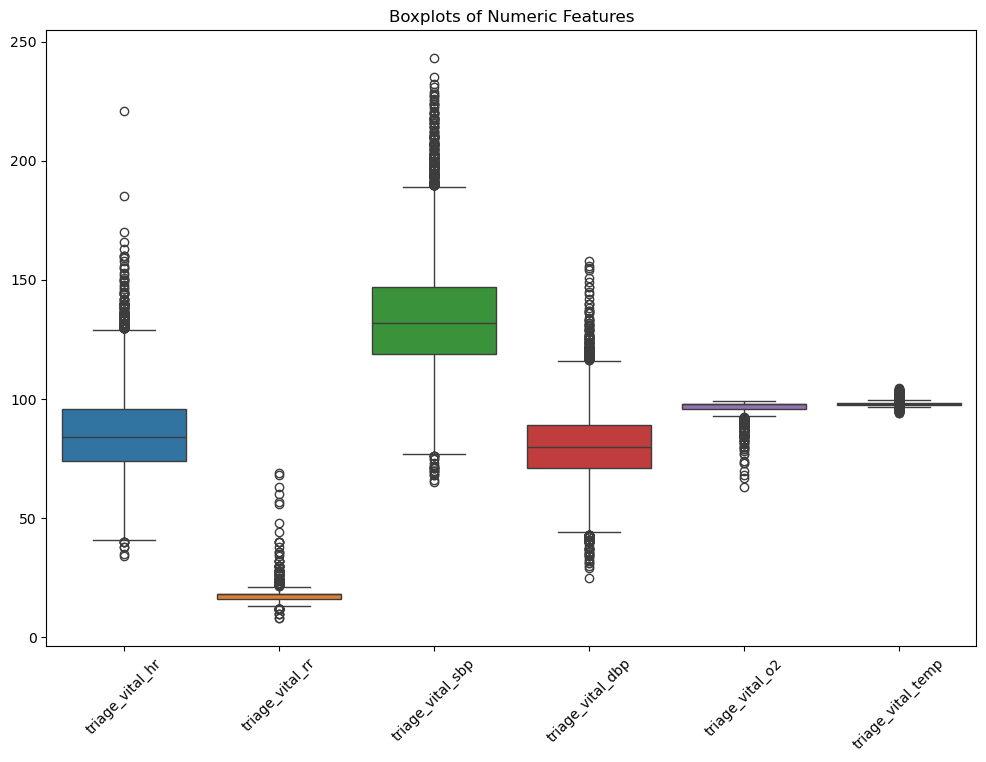

In [22]:
plt.figure(figsize=(12, 8))
numeric_features=selected_features = [ 'triage_vital_hr', 'triage_vital_rr', 'triage_vital_sbp', 
    'triage_vital_dbp', 'triage_vital_o2', 'triage_vital_temp'
]
sns.boxplot(data=df[selected_features].dropna())
plt.title('Boxplots of Numeric Features')
plt.xticks(rotation=45)
plt.show()

## Explained variance ratio plot


# Filling Missing Values

1. **Fill Missing Values in 'triage_' Columns**:
   We first identify the columns that start with `triage_`. These columns are imputed using the median strategy to handle missing values.
  


## Fill missing values


In [26]:
triage_columns = [col for col in df.columns if col.startswith('triage_')]
imputer = SimpleImputer(strategy='median')
df[triage_columns] = imputer.fit_transform(df[triage_columns])

cc_columns = [col for col in df.columns if col.startswith('cc_')]
df[cc_columns] = df[cc_columns].fillna(0)

## Fill NaN values in one-hot encoded columns with 0

In [28]:

df = df.fillna(0)



## Verify no NaN values remain

In [30]:

print(df.isnull().sum().tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [31]:
print("Original ESI values:", df["esi"].unique())
df = df[df["esi"] != 0]
df = df[df["age"] != 0]
print("Original ESI values:", df["esi"].unique())

Original ESI values: [4. 2. 3. 1. 5. 0.]
Original ESI values: [4. 2. 3. 1. 5.]


# Splitting Data and Normalizing Features

1. **Split Data into Training and Testing Datasets**:
   We split the dataset into features (`X`) and the target variable (`y`). Then, we use `train_test_split` from `sklearn` to divide the data into training and testing sets, with 80% for training and 20% for testing. The random seed is set to `42` to ensure reproducibility.


## Normalize feature values

### Define a function to replace outliers with the median

In [35]:

def replace_outliers_with_median(df, columns):
    for col in columns:
        # Calculate Q1, Q3, and IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Replace outliers with the median of the column
        median_value = df[col].median()
        df[col] = df[col].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)
    
    return df

# Columns you want to apply outlier replacement to
triage_columns = [col for col in df.columns if col.startswith('triage')]

df = replace_outliers_with_median(df, triage_columns)

# Display 
display(df[triage_columns].describe())


,triage_vital_hr,triage_vital_rr,triage_vital_sbp,triage_vital_dbp,triage_vital_o2,triage_vital_temp
count,29675.000000,29675.000000,29675.000000,29675.000000,29675.0,29675.000000
mean,83.564749,17.567060,131.141008,79.697703,98.0,98.026749
std,9.474887,0.827711,11.463977,6.846130,0.0,0.207977
min,60.000000,15.500000,102.000000,61.500000,98.0,97.500000
25%,80.000000,18.000000,126.000000,78.000000,98.0,98.000000
50%,84.000000,18.000000,132.000000,80.000000,98.0,98.000000
75%,86.000000,18.000000,134.000000,81.000000,98.0,98.000000
max,108.000000,19.500000,161.500000,97.500000,98.0,98.650000


###  Display Top Coorolation 

In [37]:
# Convert 'esi' to numeric (if it's a categorical variable, you can use encoding)
df['esi'] = pd.to_numeric(df['esi'], errors='coerce')

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlations
corr_matrix = numeric_df.corr()

# Extract the correlations of 'esi' with other columns
esi_corr = corr_matrix['esi'].drop('esi')  # Exclude self-correlation with 'esi'

# Sort and display the top 10 correlations with 'esi'
top_esi_corr = esi_corr.abs().sort_values(ascending=False).head(10)

# Display the top 10 correlations with 'esi'
print(top_esi_corr)



age                     0.277996
htn                     0.205671
cc_chestpain            0.169648
coronathero             0.147509
dysrhythmia             0.141538
cc_shortnessofbreath    0.141319
chfnonhp                0.135865
cc_suicidal             0.133906
diabmelnoc              0.133095
hyperlipidem            0.132158
Name: esi, dtype: float64


In [38]:
df.describe()

,esi,age,triage_vital_hr,triage_vital_rr,triage_vital_sbp,triage_vital_dbp,triage_vital_o2,triage_vital_temp,2ndarymalig,abdomhernia,...,previousdispo_AMA,previousdispo_Admit,previousdispo_Discharge,previousdispo_Eloped,previousdispo_LWBS after Triage,previousdispo_LWBS before Triage,previousdispo_No previous dispo,previousdispo_Observation,previousdispo_Send to L&D,previousdispo_Transfer to Another Facility
count,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.0,29675.000000,29675.000000,29675.000000,...,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000
mean,2.996529,53.172199,83.564749,17.567060,131.141008,79.697703,98.0,98.026749,0.001955,0.037439,...,0.004886,0.238180,0.462342,0.002224,0.007616,0.001719,0.262342,0.000674,0.000270,0.010211
std,0.852122,20.867452,9.474887,0.827711,11.463977,6.846130,0.0,0.207977,0.044167,0.189838,...,0.069732,0.425977,0.498588,0.047109,0.086937,0.041421,0.439915,0.025953,0.016417,0.100532
min,1.000000,18.000000,60.000000,15.500000,102.000000,61.500000,98.0,97.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,35.000000,80.000000,18.000000,126.000000,78.000000,98.0,98.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,53.000000,84.000000,18.000000,132.000000,80.000000,98.0,98.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,69.000000,86.000000,18.000000,134.000000,81.000000,98.0,98.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,107.000000,108.000000,19.500000,161.500000,97.500000,98.0,98.650000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
df.var(axis=0)
print("Original ESI values:", df["esi"].unique())

Original ESI values: [4. 2. 3. 1. 5.]


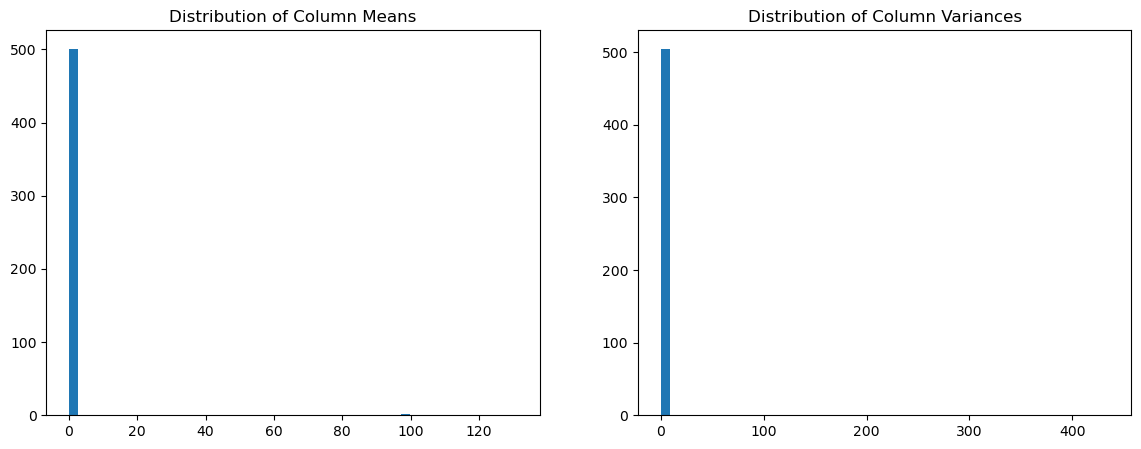

In [40]:
import matplotlib.pyplot as plt

means = df.mean(axis=0)
vars_ = df.var(axis=0)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(means, bins=50)
plt.title("Distribution of Column Means")

plt.subplot(1, 2, 2)
plt.hist(vars_, bins=50)
plt.title("Distribution of Column Variances")

plt.show()


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1) Define X and y
y = df['esi']
X = numeric_df.drop(columns=['esi'])   # all your numeric features

# 2) Label‑encode ESI → 0–4 before the split
le = LabelEncoder()
y = le.fit_transform(y)

# 3) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4) Preprocess: Scale triage_* columns
triage_cols = [c for c in X_train.columns if c.startswith('triage_')]

preprocessor = ColumnTransformer(
    transformers=[
        ("triage_scaler", StandardScaler(), triage_cols),
    ],
    remainder="passthrough"
)

# Apply transformation manually
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# 5) Apply SMOTE and overwrite X_train and y_train
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Optional: check new class distribution
print("After SMOTE:", Counter(y_train))


After SMOTE: Counter({1: 10326, 3: 10326, 2: 10326, 0: 10326, 4: 10326})


# KNN Hyperparameter Tuning

1. **Initialize the Range for K**:
   We define the range of values for `K` to test, which is from `1` to `15`. An array `mean_acc` is initialized to store the accuracy for each value of `K`.
   ```python
   Ks = 15
   mean_acc = np.zeros((Ks-1))
2. **Tune KNN for Different K Values**: We loop through the values of K (from 1 to 14), fit the K-Nearest Neighbors (KNN) model to the training data, and make predictions on the test set. The accuracy for each K is calculated and stored in the mean_acc array.The Accuracy is tested for both the test set and train set to avoid overfitting

## KNN Hyperparameter Tuning

In [44]:

Ks = 100
mean_acc = np.zeros((Ks-1))

print("\nTuning KNN...")
for n in range(1, Ks):
    neigh = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)  # use all cores
    neigh.fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, yhat)



Tuning KNN...


## Best K selection

In [46]:

best_k = mean_acc.argmax() + 1
print(f"Best K value for KNN: {best_k}")


Best K value for KNN: 1


## Train KNN with the best K

In [48]:

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)


## Add train and test set accuracy 

In [50]:

print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, knn_preds))

Train set Accuracy:  0.9995157853960875
Test set Accuracy:  0.3823083403538332


# SVM Hyperparameter Tuning

1. **Define Range of C Values**:
   ```python
   svm_accuracies = {}
2. **Tune SVM for Different C Values**
3. **Select the Best C**
4. **Train SVM with the Best C**

## SVM Hyperparameter Tuning


In [53]:
#kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernels = [ 'rbf']
svm_accuracies = {}
C_fixed = 1

print("\nTuning SVM kernels (with C=1)...")

def train_and_evaluate(kernel):
    svm = SVC(kernel=kernel, C=C_fixed)
    svm.fit(X_train, y_train)
    svm_preds = svm.predict(X_test)
    accuracy = accuracy_score(y_test, svm_preds)
    print(f"SVM Accuracy with kernel={kernel}: {accuracy:.4f}")
    return kernel, accuracy

# Reduced n_jobs to a reasonable number (2) instead of using all cores (-1)
# This helps prevent system overload and KeyboardInterrupt issues
results = Parallel(n_jobs=2)(delayed(train_and_evaluate)(kernel) for kernel in kernels)
svm_accuracies = dict(results)



Tuning SVM kernels (with C=1)...


## Best C selection

In [55]:
best_kernel = max(svm_accuracies, key=svm_accuracies.get)
print(f"Best kernel for SVM: {best_kernel}")


Best kernel for SVM: rbf



## Retrain on full training set with best kernel

In [57]:

svm = SVC(kernel=best_kernel, C=C_fixed)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print(f"Final Test Accuracy: {accuracy_score(y_test, svm_preds):.4f}")


Final Test Accuracy: 0.2770


## Add train and test set accuracy


In [ ]:
print("Train set Accuracy: ", accuracy_score(y_train, svm.predict(X_train)))
print("Test set Accuracy: ", accuracy_score(y_test, svm_preds))

# Decision Tree Hyperparameter Tuning
#### Define Range of Max Depth Values
We define a list of possible max_depth values for the Decision Tree model, ranging from 1 to 20. Two lists, train_accuracies and test_accuracies,are created to store accuracy for both training and test sets.

In [ ]:
depth_values = list(range(1, 45))  # Max depth from 1 to 20
train_accuracies = []
test_accuracies = []
best_depth = None



### Tune Decision Tree for Different Max Depth Values
We iterate over the defined max_depth values, training a DecisionTreeClassifier for each. The model is evaluated on both the training and test sets, and the accuracy is stored.

In [ ]:
for depth in depth_values:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=150)
    dt.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, dt.predict(X_train))
    test_acc = accuracy_score(y_test, dt.predict(X_test))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"Max Depth={depth}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f}")
    
    # Track the best depth based on test accuracy
    if best_depth is None or test_acc > best_depth[1]:
        best_depth = (depth, test_acc)


In [ ]:
# Decision Tree with the best max depth
dt = DecisionTreeClassifier(max_depth=best_depth[0], random_state=150)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(depth_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(depth_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.legend()
plt.grid(True)
plt.show()


## Random Forest Classifier

In [ ]:
max_depth_values = range(1, 19)  # Test max_depth from 1 to 20
random_state_values = [150]  # Test different random states

best_params = None
best_accuracy = 0

# Iterate over all combinations of max_depth and random_state
for max_depth in max_depth_values:
    for random_state in random_state_values:
        # Train the Random Forest model
        rf = RandomForestClassifier(max_depth=max_depth, random_state=random_state, n_estimators=100, class_weight='balanced')
        rf.fit(X_train, y_train)
        
        # Predict on the test set
        rf_preds = rf.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, rf_preds)
        
        # Update best parameters if current accuracy is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'max_depth': max_depth, 'random_state': random_state}

# Train the best model
rf_best = RandomForestClassifier(max_depth=best_params['max_depth'], random_state=best_params['random_state'], n_estimators=200, class_weight='balanced')
rf_best.fit(X_train, y_train)
rf_preds_best = rf_best.predict(X_test)

# Display results
print("\nBest Random Forest Parameters:")
print(f"Max Depth: {best_params['max_depth']}, Random State: {best_params['random_state']}")
print("Best Test Set Accuracy: ", best_accuracy)
print("\nRandom Forest Performance with Best Parameters:")
print("Train set Accuracy: ", accuracy_score(y_train, rf_best.predict(X_train)))
print("Test set Accuracy: ", accuracy_score(y_test, rf_preds_best))
print("Classification Report:\n", classification_report(y_test, rf_preds_best))

# XGBoost Hyperparameter Tuning


In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1) split
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, train_size=0.3, stratify=y_train, random_state=42
)

# 2) encode labels to 0–4
le = LabelEncoder()
y_train_sub = le.fit_transform(y_train_sub)   # maps [1,2,3,4,5] → [0,1,2,3,4]
y_val   = le.transform(y_val)             # same mapping for validation

In [ ]:
print("\nTuning XGBoost...")
param_grid_xgb = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [100, 200]
}
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(y.unique()), tree_method='hist', n_jobs=-1)
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train_sub, y_train_sub)
best_xgb = grid_search_xgb.best_estimator_
print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")

In [ ]:
# Train XGBoost
xgb_model = best_xgb
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("XGBoost Train Accuracy:", accuracy_score(y_train, xgb_model.predict(X_train)))
print("XGBoost Test Accuracy:", accuracy_score(y_test, xgb_preds))


##  Ordinal Regression

In [ ]:
from sklearn.metrics import confusion_matrix

y_train_numeric = y_train.cat.codes if hasattr(y_train, 'cat') else y_train.astype(int)
y_test_numeric = y_test.cat.codes if hasattr(y_test, 'cat') else y_test.astype(int)

ord_model = mord.LogisticIT()

ord_model.fit(X_train, y_train_numeric)

ord_preds = ord_model.predict(X_test)

print("\nOrdinal Regression Performance:")
print("Train set Accuracy: ", accuracy_score(y_train_numeric, ord_model.predict(X_train)))
Xgboostacc=accuracy_score(y_test_numeric, ord_preds)
print("Test set Accuracy: ", accuracy_score(y_test_numeric, ord_preds))
print("Classification Report:\n", classification_report(y_test_numeric, ord_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test_numeric, ord_preds))

#### Visualize Performance with a Graph
We plot the accuracies for different max_depth values to analyze the effect of increasing depth on model performance.

## Create and train a linear regression model

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train_numeric)

### Make predictions and round to nearest integer

In [ ]:
linear_preds_raw = linear_model.predict(X_test)
linear_preds = np.round(linear_preds_raw).astype(int)

### Ensure predictions are within valid range

In [ ]:
# Get the minimum and maximum class values
min_class = min(y_train_numeric)
max_class = max(y_train_numeric)-1
print(min_class,max_class)
# Clip predictions to be within the valid range
linear_preds_raw = np.clip(linear_preds_raw, min_class, max_class)

# Round down (floor) the predictions instead of rounding to nearest integer
linear_preds = np.floor(linear_preds_raw).astype(int)

In [ ]:
# Evaluate performance
print("\nLinear Regression with Rounding Performance:")
print("Train set Accuracy: ", accuracy_score(y_train_numeric, 
                                            np.clip(np.round(linear_model.predict(X_train)).astype(int), 
                                                   min_class, max_class)))
print("Test set Accuracy: ", accuracy_score(y_test_numeric, linear_preds))
print("Classification Report:\n", classification_report(y_test_numeric, linear_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test_numeric, linear_preds))

In [ ]:
#  Compare raw predictions vs rounded predictions to understand if the method is valid
print("\nSample of raw vs rounded predictions:")
sample_indices = np.random.choice(range(len(X_test)), min(10, len(X_test)), replace=False)
for idx in sample_indices:
    print(f"True: {y_test_numeric.iloc[idx] if hasattr(y_test_numeric, 'iloc') else y_test_numeric[idx]}, "
          f"Raw prediction: {linear_preds_raw[idx]:.2f}, "
          f"Rounded: {linear_preds[idx]}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(y_test_numeric, linear_preds_raw, alpha=0.5)
ax1.plot([min(y_test_numeric), max(y_test_numeric)], 
         [min(y_test_numeric), max(y_test_numeric)], 
         'r--', label='Perfect prediction')
ax1.set_xlabel('True Values')
ax1.set_ylabel('Raw Predictions')
ax1.set_title('Raw Predictions vs True Values')
ax1.legend()


jitter = np.random.normal(0, 0.05, size=len(y_test_numeric))
ax2.scatter(y_test_numeric + jitter, linear_preds, alpha=0.5)
ax2.plot([min(y_test_numeric), max(y_test_numeric)], 
         [min(y_test_numeric), max(y_test_numeric)], 
         'r--', label='Perfect prediction')
ax2.set_xlabel('True Values')
ax2.set_ylabel('Rounded Predictions')
ax2.set_title('Rounded Predictions vs True Values')
ax2.legend()

plt.tight_layout()
plt.show()



# Model Evaluation

1. **KNN Performance**:
   After training the KNN model, we evaluate its performance by printing the accuracy and the classification report. The accuracy is calculated using `accuracy_score` and the classification report is generated using `classification_report` from `sklearn`.
2. **SVM Performance**: Similarly, we evaluate the performance of the SVM model by printing its accuracy and the classification report. The accuracy is calculated and the classification report is generated in the same way as for KNN.
3. **ADD Performance** : We also evaluate the Performance of the model itirating through the best depths and Finding it 


## Model Evaluation

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# — assume these preds and best params already exist —
# best_k, knn_preds
# svm_preds
# best_depth, dt_preds
# y_test

# 1) Compute accuracies
knn_acc = accuracy_score(y_test, knn_preds)
svm_acc = accuracy_score(y_test, svm_preds)
dt_acc  = accuracy_score(y_test, dt_preds)

# 2) Print performance (as you had)
print("\nKNN Performance:")
print(f"Best K={best_k} | Accuracy: {knn_acc:.4f}")
print("Classification Report:\n", classification_report(y_test, knn_preds))

print("\nSVM Performance:")
print(f"Accuracy: {svm_acc:.4f}")
print("Classification Report:\n", classification_report(y_test, svm_preds))

print("\nDecision Tree Performance:")
print(f"Best Max Depth={best_depth} | Accuracy: {dt_acc:.4f}")
print("Classification Report:\n", classification_report(y_test, dt_preds))


# 3) Bar chart of accuracies
models    = ['KNN', 'SVM', 'Decision Tree']
accuracies = [knn_acc, svm_acc, dt_acc]
colors     = ['#1f77b4', '#ff7f0e', '#2ca02c']  # feel free to pick your own

plt.figure(figsize=(10, 5))
bars = plt.bar(models, accuracies, color=colors)

# annotate bars
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.005,
             f'{h:.4f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, max(accuracies) + 0.1)
plt.ylabel('Accuracy')
plt.title('KNN vs SVM vs Decision Tree Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()





In [ ]:
# Calculate accuracy scores
dt_accuracy = accuracy_score(y_test, dt_preds)
ord_accuracy = accuracy_score(y_test, ord_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)  # Added Random Forest
xgb_accuracy = accuracy_score(y_test, xgb_preds)

# Print accuracy scores
print(f"Decision Tree | Best Max Depth={best_depth} | Accuracy: {dt_accuracy:.4f}")
print(f"Ordinal Regression | Accuracy: {ord_accuracy:.4f}")
print(f"Random Forest | Accuracy: {rf_accuracy:.4f}")  # Added Random Forest
print(f"XGBoost | Accuracy: {xgb_accuracy:.4f}")

# Print classification reports
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dt_preds))

print("\nOrdinal Regression Classification Report:")
print(classification_report(y_test, ord_preds))

print("\nRandom Forest Classification Report:")  # Added Random Forest
print(classification_report(y_test, rf_preds))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))

# Create a bar chart to compare accuracies
models = ['Decision Tree', 'Ordinal Regression', 'Random Forest', 'XGBoost']  # Added Random Forest
accuracies = [dt_accuracy, ord_accuracy, rf_accuracy, xgb_accuracy]  # Added Random Forest

plt.figure(figsize=(12, 6))  # Increased width to accommodate the additional bar
bars = plt.bar(models, accuracies, color=['#3498db', '#2ecc71', '#9b59b6', '#e74c3c'])  # Added color for Random Forest

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, max(accuracies) + 0.1)  # Add some space above the highest bar
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# — 1) Prepare X and y —
y = df['esi']                              # original ESI labels 1–5
X = numeric_df.drop(columns=['esi'])       # your numeric feature DataFrame

# — 2) Encode labels 1–5 → 0–4 —
le = LabelEncoder()
y_enc = le.fit_transform(y)                # now 0–4

# — 3) Split into train/test (stratify to preserve class balance) —
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.20,
    random_state=42,
    stratify=y_enc
)

# — 4) Scale features —
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# — 5) One‑hot encode labels for Keras —
num_classes = len(le.classes_)             # should be 5
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

# — 6) Build the neural network —
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64,  activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# — 7) Compile —
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# — 8) Train —
history = model.fit(
    X_train, 
    y_train_cat,
    validation_split=0.1,
    epochs=200,
    batch_size=32,
    verbose=2
)

# — 9) Evaluate on held‑out test set —
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Test accuracy: {accuracy:.4f}")
